## Normal VCM Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures for the Gaussian base distribution with Identity Link and covariance matrix $\Gamma$ structured under variance component model framework as follows:

$$
\Gamma = \sigma_1 * \mathbf{1_{n} 1_{n}^\top}
$$

In this example simulate three fixed effects $\beta \sim$ randn(p) where p = 3 fixed effects.

We run each scenario 100 times and compare the fit with that of GLMM's random intercept model from MixedModels.jl. 

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [3]:
p = 3    # number of fixed effects, including intercept
m = 1    # number of variance components
# true parameter values
Random.seed!(1234)
βtrue = randn(p)
Σtrue = [0.1]
τtrue = [100]

# generate data
intervals = zeros(p + m, 2) #hold intervals
curcoverage = zeros(p + m) #hold current coverage resutls
trueparams = [βtrue; Σtrue; τtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2; 5; 10; 15; 20; 25]
nsims = 100

100

In [8]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_normal$(nsims)reps_sim.csv", ','))
ΣMseresult = vec(readdlm("mse_Sigma_multivariate_normal$(nsims)reps_sim.csv", ','))
fittimes_QC = vec(readdlm("fittimes_multivariate_normal$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[8]:1


1800-element Vector{Float64}:
 0.079834597
 0.068266047
 0.066604129
 0.069598283
 0.076582434
 0.091161046
 0.02505433
 0.128957031
 0.02764908
 0.089469967
 0.054592986
 0.070673269
 0.084729197
 ⋮
 4.1273854
 3.235318813
 5.512386841
 6.32370069
 1.035716943
 3.285154403
 1.391387107
 1.10481726
 1.605030369
 3.886047178
 6.099998335
 0.86138499

In [9]:
fittimes_GLMM = vec(readdlm("fittimes_GLMM_normal$(nsims)reps_sim.csv", ','))

1800-element Vector{Float64}:
 0.189375704
 0.000473277
 0.000397927
 0.000397148
 0.000363314
 0.000367863
 0.000377184
 0.00035822
 0.000335968
 0.000353235
 0.000344504
 0.000363556
 0.00035871
 ⋮
 0.092313507
 0.052391948
 0.051575765
 0.053147395
 0.050641879
 0.053153823
 0.079142337
 0.05444347
 0.050940457
 0.053038514
 0.051289953
 0.078309434

In [10]:
#simulation parameters
@info "making results table Quasi-Copula"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, Σmse = ΣMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_QC)
timedf1 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf1, Dict(:fittimes_function => "se"))
timedf1[!, :nobs] = Meta.parse.(timedf1[!, :samplesize]) .* Meta.parse.(timedf1[!, :obssize])
timedf1[!, :fitmin] = timedf1[!, :fittime] - timedf1[!, :se]
timedf1[!, :fitmax] = timedf1[!, :fittime] + 2 * timedf1[!, :se]
timedf1[!, :perobsratio] = timedf1[!, :fittime] ./ timedf1[!, :nobs]
timedf1

┌ Info: making results table Quasi-Copula
└ @ Main In[10]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,NaN,NaN,200,NaN,NaN,NaN
2,100,5,0.0731537,0.00222152,500,0.0709322,0.0775967,0.000146307
3,100,10,0.0844677,0.00242178,1000,0.0820459,0.0893112,8.44677e-5
4,100,15,0.0848414,0.00247659,1500,0.0823648,0.0897946,5.65609e-5
5,100,20,0.091981,0.00207503,2000,0.089906,0.0961311,4.59905e-5
6,100,25,0.101884,0.00283875,2500,0.0990451,0.107561,4.07535e-5
7,1000,2,0.143626,0.0066441,2000,0.136981,0.156914,7.18128e-5
8,1000,5,0.16652,0.00552734,5000,0.160993,0.177575,3.3304e-5
9,1000,10,0.214838,0.00872905,10000,0.206109,0.232296,2.14838e-5


In [11]:
#simulation parameters
@info "making results table GLMM"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, Σmse = ΣMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_GLMM)
timedf2 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf2, Dict(:fittimes_function => "se"))
timedf2[!, :nobs] = Meta.parse.(timedf2[!, :samplesize]) .* Meta.parse.(timedf2[!, :obssize])
timedf2[!, :fitmin] = timedf2[!, :fittime] - timedf2[!, :se]
timedf2[!, :fitmax] = timedf2[!, :fittime] + timedf2[!, :se]
timedf2[!, :perobsratio] = timedf2[!, :fittime] ./ timedf2[!, :nobs]
timedf2

┌ Info: making results table GLMM
└ @ Main In[11]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax
,String,String,Float64,Float64,Int64,Float64,Float64
1,100,2,0.00226427,0.00189002,200,0.000374253,0.00415429
2,100,5,0.000422061,2.70297e-6,500,0.000419358,0.000424764
3,100,10,0.000515812,3.11529e-6,1000,0.000512697,0.000518927
4,100,15,0.00063659,3.60202e-6,1500,0.000632988,0.000640192
5,100,20,0.0007918,2.80985e-5,2000,0.000763701,0.000819899
6,100,25,0.000856611,2.69111e-6,2500,0.00085392,0.000859302
7,1000,2,0.00169234,7.36744e-6,2000,0.00168497,0.0016997
8,1000,5,0.00219223,5.58091e-6,5000,0.00218665,0.00219781
9,1000,10,0.00532323,0.00110656,10000,0.00421667,0.00642979


┌ Warning: RCall.jl: Warning: Removed 1 row(s) containing missing values (geom_path).
│ Warning: Removed 1 rows containing missing values (geom_point).
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


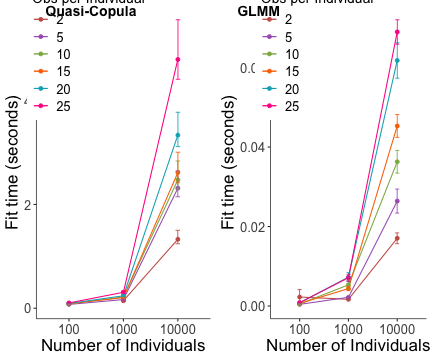

RObject{VecSxp}


In [13]:
########### plot the runtimes
using RCall
@rput timedf1
@rput timedf2
R"""
library(ggplot2)
library(cowplot)
timedf1$obssize = factor(timedf1$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf1$samplesize = factor(timedf1$samplesize, levels = c('100', '1000', '10000'))

fittime_1 = ggplot(timedf1, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

timedf2$obssize = factor(timedf2$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf2$samplesize = factor(timedf2$samplesize, levels = c('100', '1000', '10000'))

fittime_2 = ggplot(timedf2, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

fittime_nsamples = plot_grid(fittime_1, fittime_2, labels = c("Quasi-Copula", "GLMM"))
"""

In [14]:
R"""
ggsave('fittime_nsamples_normal_vs_glmm.png', fittime_nsamples, width = 15, height = 17, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "fittime_nsamples_normal_vs_glmm.png"


In [23]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βΣτcoverage = readdlm("beta_sigma_tau_coverage_normal$(nsims)reps_sim.csv", ',')

m  = 1

covdf = DataFrame(Matrix(transpose(βΣτcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["Σ$i" for i in 1:m]; ["τ"]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["Σ$i" for i in 1:m]; "τ"])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,Σ1
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.66, 0.0476095)","(0.74, 0.0440844)","(0.73, 0.0446196)","(0.0, 0.0)"
2,N: 100 ni: 5,"(0.71, 0.0456048)","(0.74, 0.0440844)","(0.86, 0.0348735)","(0.0, 0.0)"
3,N: 100 ni: 10,"(0.6, 0.0492366)","(0.83, 0.0377525)","(0.85, 0.035887)","(0.0, 0.0)"
4,N: 100 ni: 15,"(0.59, 0.0494311)","(0.88, 0.0326599)","(0.92, 0.027266)","(0.0, 0.0)"
5,N: 100 ni: 20,"(0.52, 0.0502117)","(0.88, 0.0326599)","(0.86, 0.0348735)","(0.0, 0.0)"
6,N: 100 ni: 25,"(0.53, 0.0501614)","(0.79, 0.040936)","(0.84, 0.0368453)","(0.0, 0.0)"
7,N: 1000 ni: 2,"(0.74, 0.0440844)","(0.71, 0.0456048)","(0.81, 0.0394277)","(0.0, 0.0)"
8,N: 1000 ni: 5,"(0.72, 0.0451261)","(0.84, 0.0368453)","(0.83, 0.0377525)","(0.0, 0.0)"
9,N: 1000 ni: 10,"(0.66, 0.0476095)","(0.9, 0.0301511)","(0.96, 0.0196946)","(0.0, 0.0)"


In [24]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult = vec(readdlm("mse_beta_multivariate_normal$(nsims)reps_sim.csv", ','))
ΣMseresult = vec(readdlm("mse_Sigma_multivariate_normal$(nsims)reps_sim.csv", ','))
τMseresult = vec(readdlm("mse_tau_multivariate_normal$(nsims)reps_sim.csv", ','))

βMseresult_GLMM = vec(readdlm("mse_beta_GLMM_normal$(nsims)reps_sim.csv", ','))
ΣMseresult_GLMM = vec(readdlm("mse_Sigma_GLMM_normal$(nsims)reps_sim.csv", ','))
τMseresult_GLMM = vec(readdlm("mse_tau_GLMM_normal$(nsims)reps_sim.csv", ','))

p = 3; m = 1
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf1 = DataFrame(βmse = βMseresult, Σmse = ΣMseresult, τmse = τMseresult,
    samplesize = sample_sizes, obssize = obs_sizes)

msedf2 = DataFrame(βmse = βMseresult_GLMM, Σmse = ΣMseresult_GLMM, τmse = τMseresult_GLMM,
    samplesize = sample_sizes, obssize = obs_sizes)

#rename to make parsing easier for R.

msedf1 = deepcopy(msedf1)
rename!(msedf1, ["betamse"
    "Sigmamse"
        "taumse"
    "samplesize"
 "obssize"]);

msedf2 = deepcopy(msedf2)
rename!(msedf2, ["betamse"
    "Sigmamse"
        "taumse"
    "samplesize"
 "obssize"]);

mses = [msedf1[!, :betamse]; msedf1[!, :Sigmamse]; msedf1[!, :taumse]; msedf2[!, :betamse]; msedf2[!, :Sigmamse]; msedf2[!, :taumse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [collect([repeat(msedf1[!, :obssize], 3)]...) ; collect([repeat(msedf2[!, :obssize], 3)]...)]
#40
samplesize = [collect([repeat(msedf1[!, :samplesize], 3)]...) ; collect([repeat(msedf2[!, :samplesize], 3)]...)]

parameters = [collect([repeat(string.([:beta, :Sigma, :tau]), inner = nsims * length(ns) * length(samplesizes))]...) ; collect([repeat(string.([:beta, :Sigma, :tau]), inner = nsims * length(ns) * length(samplesizes))]...)]
robust = [collect([repeat(["Gaussian Quasi-Copula"], 3 * nsims * length(ns) * length(samplesizes))]...); collect([repeat(["Gaussian LMM"],  3 * nsims * length(ns) * length(samplesizes))]...)]

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,3.13325e-5,2,100,beta,Gaussian Quasi-Copula
2,2.10862e-5,2,100,beta,Gaussian Quasi-Copula
3,4.49656e-5,2,100,beta,Gaussian Quasi-Copula
4,6.37487e-6,2,100,beta,Gaussian Quasi-Copula
5,1.63287e-5,2,100,beta,Gaussian Quasi-Copula
6,0.000108321,2,100,beta,Gaussian Quasi-Copula
7,3.18754e-5,2,100,beta,Gaussian Quasi-Copula
8,0.000119777,2,100,beta,Gaussian Quasi-Copula
9,0.000176306,2,100,beta,Gaussian Quasi-Copula


┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Warning: package ‘data.table’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


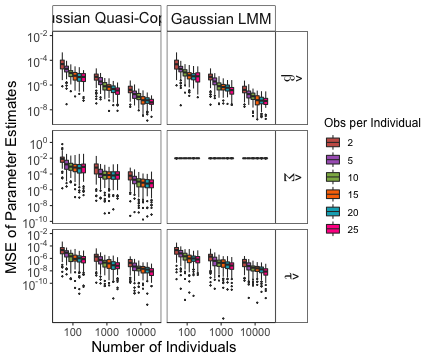

RObject{VecSxp}


In [25]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-8]
msedfR[parameters == "beta",y_max := 10^-2]
msedfR[parameters == "Sigma",y_min := 10^-5]
msedfR[parameters == "Sigma",y_max := 10^1]
msedfR[parameters == "tau",y_min := 10^-8]
msedfR[parameters == "tau",y_max := 10^-2]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10', '15', '20', '25'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'Sigma', 'tau'), labels = c(beta = expression(hat(bold(beta))), Sigma = expression(hat(bold(Sigma))[]), tau = expression(hat(bold(tau)))))
msedfR$robust <- factor(msedfR$robust, levels = c('Gaussian Quasi-Copula', 'Gaussian LMM'),
    labels = c(expression(paste("Gaussian Quasi-Copula")), expression(paste("Gaussian LMM"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=11),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 15), 
        axis.title.y = element_text(size = 15), legend.title = element_text(size = 12),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=10), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(size=15, face="bold"),
        strip.text.x = element_text(size=15)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Number of Individuals", y = "MSE of Parameter Estimates", fill = "Obs per Individual") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [26]:
R"""
ggsave('updated_msefacetplot_normal.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_normal.png"
